# Week 4 - classification



## Agenda

1. What is classification?
2. Logistic Regression
3. Evaluating a classification model
4. k-Nearest-Neighbor


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read ISLP default data
df = pd.read_csv(
    "https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/Default.csv"
)

In [3]:
def plot_decision_boundary(x1, x2, y, model, thresholds=[0.5], figsize=(7, 7), ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)

    x1_min, x1_max = x1.min(), x1.max()
    x2_min, x2_max = x2.min(), x2.max()
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 1_000), np.linspace(x2_min, x2_max, 1_000))

    mesh_df = pd.DataFrame({
        x1.name: xx.ravel(),
        x2.name: yy.ravel()
    })

    Z = model.predict_proba(mesh_df)[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contour(xx, yy, Z, levels=thresholds, cmap="Greys", vmin=0, vmax=0.6)

    sns.scatterplot(
        x=x1,
        y=x2,
        hue=y,
        alpha=0.5,
        edgecolor="white",
        linewidth=1,
        ax=ax
    )

    if title:
        ax.set_title(title)


## Analysis and cleaning

### Looking at data

In [4]:
df.sample(10)

,default,student,balance,income
3096,No,Yes,294.656488,11681.462332
4875,No,No,0.000000,37825.221415
9107,No,No,1549.263306,43240.459026
8596,No,Yes,1757.845459,17426.519712
5658,No,No,1236.158124,19682.710901
2680,No,No,682.439661,17992.971178
4027,No,No,1121.496586,39395.899358
169,No,No,666.608881,30438.468827
343,No,No,749.608004,41423.941173
983,No,No,953.929818,32640.144048


In [5]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


There's one more thing we should always check when dealing with classification problems - how unbalanced are our classes? Perfectly balanced classes (that is, each class is 50% of the dataset) don't exist in the real world, and most problems actually have quite severe imbalance. That's because we're often interested in predicting events that are quite rate.


In [7]:
df.value_counts("default")

default
No     9667
Yes     333
Name: count, dtype: int64

Only about 3.3 % of all observations in the dataset have defaulted. This will be a problem that we'll have to get back to later.

### Transforming

The dataset is quite clean. The only transformation I want to apply is converting the `student` and `default` columns into binary 0/1 instead of Yes/No.


In [8]:
value_map = {"Yes": 1, "No": 0}
df["student"] = df["student"].map(value_map)
df["default"] = df["default"].map(value_map)

### Plotting

Let's visually investigate the relationship between the target variable `default` and the predictors.


<Axes: xlabel='balance', ylabel='Density'>

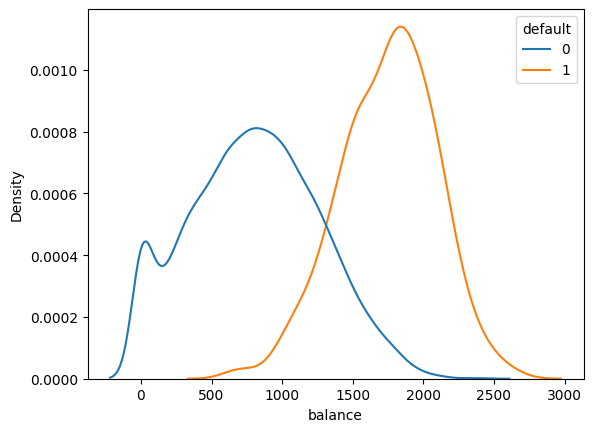

In [9]:
sns.kdeplot(data=df, x="balance", hue="default", common_norm=False)

<Axes: xlabel='income', ylabel='Density'>

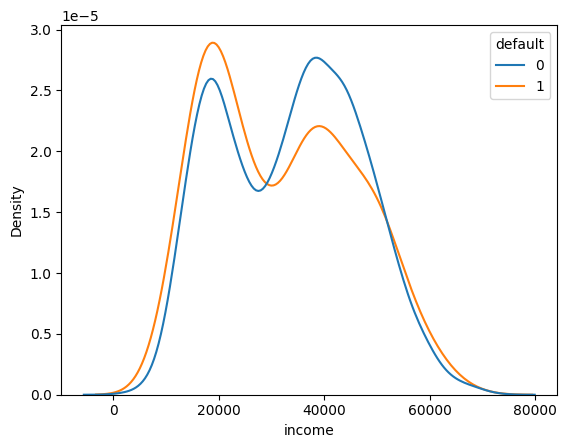

In [10]:
sns.kdeplot(data=df, x="income", hue="default", common_norm=False)

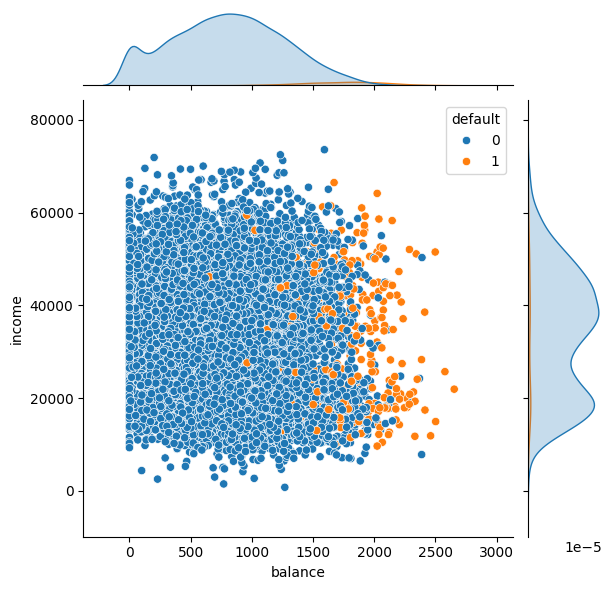

In [11]:
sns.jointplot(data=df, x="balance", y="income", hue="default")

The plot is quite crowded, and you can barely see any values that have default=1, because the default=0 values overwhelm it.

Let's improve this.


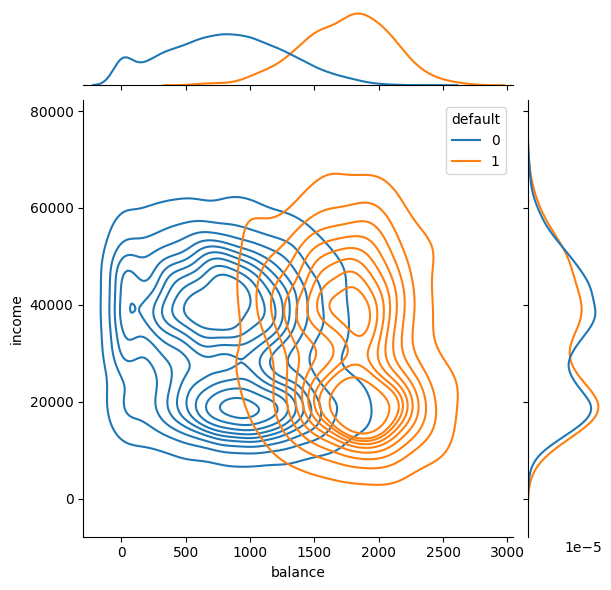

In [12]:
sns.jointplot(
    data=df,
    x="balance",
    y="income",
    hue="default",
    kind="kde",
    common_norm=False,
    marginal_kws={"common_norm": False},
)


A way better plot!


In [13]:
df.groupby("student")["default"].mean()


student
0    0.029195
1    0.043139
Name: default, dtype: float64

## Modelling


In [14]:
from sklearn.model_selection import train_test_split


We will now split the dataset into train, validation and test sets. You are already familiar with training and validation datasets - the training set is for training the model, while the validation set is for checking how different models perform on unseen data. The test set is for reporting the performance of the final model. We only make predictions on the test set using the final model that we chose based on how it performs on the test set. 



In [95]:
# First split into train and test (80/20)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)

# Then split off a validation set from the training set (75/25, which is 60/20 of original)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=10)


What are these three datasets for? 
- The *training* set is for fitting our models. When we call .fit(), we pass the training set as an argument (and only the training set).
- The *validation* set is for choosing the best model in terms of the algorithm and its *hyperparameters*. 
- The *test* set is for reporting the performance of the final model. During any modelling, we should only do predict on our test data once, and that should be the last thing that we do.


In [96]:
target = "default"
y_train = df_train[target]

### Simple Logistic Regression


In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
X_bal = df_train[["balance"]]

model_bal = LogisticRegression(penalty=None)
model_bal.fit(X_bal, y_train)

LogisticRegression(penalty=None)

Now we can extract predictions from our model. Let's do that for the training data.

In [99]:
y_pred_proba = model_bal.predict_proba(X_bal)
y_pred_proba

array([[0.99045657, 0.00954343],
       [0.61637403, 0.38362597],
       [0.99873695, 0.00126305],
       ...,
       [0.99761459, 0.00238541],
       [0.92406862, 0.07593138],
       [0.37568314, 0.62431686]], shape=(6000, 2))

`predict_proba` gives probabilities for every class. We have two classes - therefore two probabilities. These probabilities add up to 1. 

Since it's a binary problem, we usually care about the probability of the positive class P(default=1). Let's use just that probability.


In [100]:
y_pred_proba = y_pred_proba[:, 1]
y_pred_proba


array([0.00954343, 0.38362597, 0.00126305, ..., 0.00238541, 0.07593138,
       0.62431686], shape=(6000,))

In [101]:
df_train["pred_proba"] = y_pred_proba

In [102]:
df_train.sample(10)

,default,student,balance,income,pred_proba
7663,0,0,628.875536,48380.510839,0.000678
4393,0,0,711.525816,35468.382154,0.001073
6966,0,0,698.572453,44949.269084,0.000998
292,0,1,1082.391497,15175.361215,0.008360
7348,0,0,0.000000,52632.329894,0.000021
2605,0,0,76.476089,27283.691744,0.000032
2193,0,0,1153.021310,20586.278109,0.012328
4045,0,0,425.053745,37351.355515,0.000219
7725,0,0,411.537627,30065.444347,0.000203
9267,0,1,1578.289555,12778.598495,0.117060


Currently our predictions are floats between 0 and 1 - predicted probabilities. However, for many of the ways we will evaluate our classification models, we need binary predictions. 

In other words, we should apply some sort of a threshold to these probabilities.

In [103]:
y_pred = y_pred_proba > 0.5
df_train["y_pred"] = y_pred

Let's plot the predicted probability against `balance`.

<Axes: xlabel='balance', ylabel='default'>

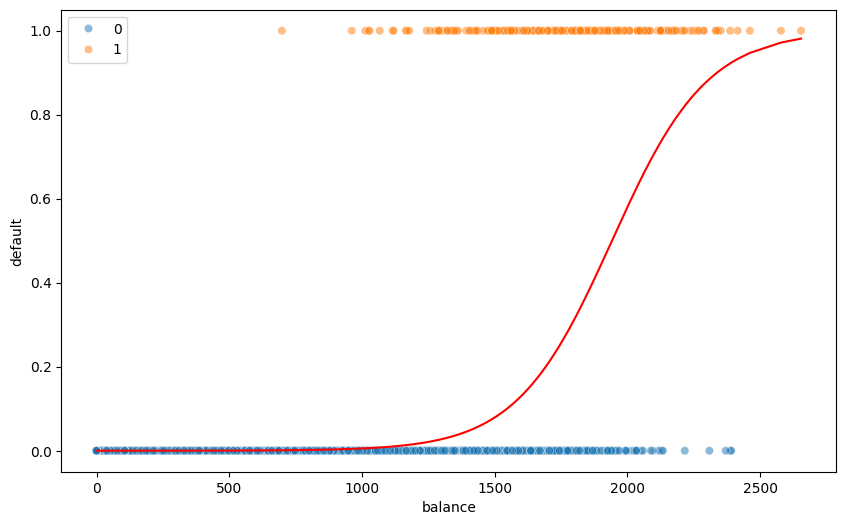

In [107]:
import numpy as np
import seaborn as sns

# Create figure
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_train, x="balance", y="default", hue="default", alpha=0.5
)
sns.lineplot(x=X_bal["balance"], y=y_pred_proba, color="red")


Now how should we evaluate if our model is any good?

Let's look how accurate our model is - what is the proportion of cases where our model's predictions matches the true labels?


In [108]:
np.mean(y_pred == y_train)

np.float64(0.9725)

### Task - compare against "always 0" model

Is this a good model? What would the accuracy be if our model always predicted 0?

Calculate the accuracy of a "model" that always predicts 0.


In [27]:
zeros = np.zeros(len(y_train))
np.mean(zeros == y_train)

np.float64(0.9668333333333333)

our model is just a tiny bit better than a model that always predicts 0!

The problem is not in our model, but in the metric. Since our dataset contains severe class imbalance, accuracy is not an adequate metric. Let's look into two more metrics that will help us reason about the performance of our model.

### Task - recall

Calculate recall. Recall - of all positive cases (cases that are actually default=1), what is the share that our model identified?


In [32]:
# Hint
# You will need these operations:
y_train == 1
(y_pred == 1) & (y_train == 1)
np.sum

<function sum at 0x108577f70>

In [33]:
# recall - what proportion of positive cases does our model recall?
actual_positives = np.sum(y_train == 1)
true_positives = np.sum((y_pred == 1) & (y_train == 1))
true_positives / actual_positives

np.float64(0.3015075376884422)

### Task - precision

Calculate precision. Precision - of all positive predictions (model predicts default=1), what share is actually positive?


In [109]:
# precision - of all predicted positive cases, how many are actually positive?
actual_positives = np.sum(y_pred == 1)
true_positives = np.sum((y_pred == 1) & (y_train == 1))
true_positives / actual_positives

np.float64(0.6976744186046512)

Our model currently is not very useful, because it only identifies 30% of the default at a threshold of 0.5 percent.


By the way, we don't have to remember the formulas for precision, recall and accuracy (or for any of the metrics we will look into). scikit-learn provides functions for them.

In [111]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print("Accuracy: ", accuracy_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))
print("Precision: ", precision_score(y_train, y_pred))

Accuracy:  0.9725
Recall:  0.3015075376884422
Precision:  0.6976744186046512


### Task

- Fit a logistic regression model with two predictors - `balance` and `income`. 
- Plot the decision boundary using `plot_decision_boundary` function.
- Report precision, recall and accuracy of the model.


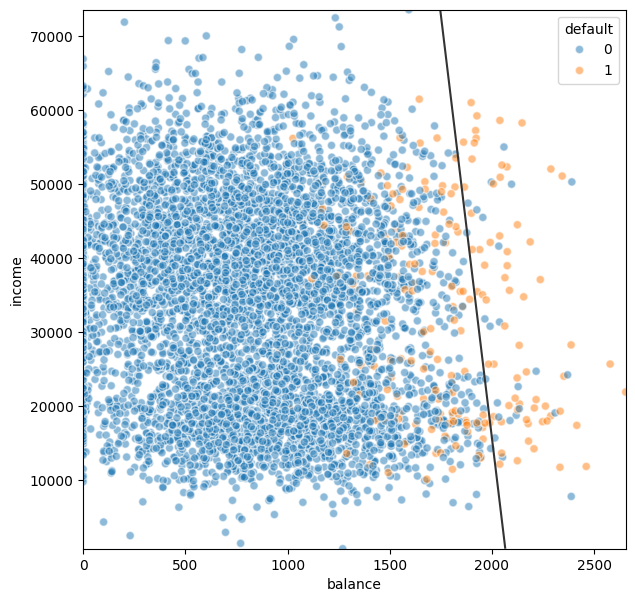

In [112]:
X_bal_inc = df_train[["balance", "income"]]

logreg_bal_inc = LogisticRegression()
logreg_bal_inc.fit(X_bal_inc, y_train)

y_pred_proba = logreg_bal_inc.predict_proba(X_bal_inc)[:, 1]

plot_decision_boundary(X_bal_inc["balance"], X_bal_inc["income"], y_train, logreg_bal_inc)



Now let's add polynomial features to our model. 

In [37]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_bal_inc)

# Fit logistic regression with polynomial features
model_poly = LogisticRegression()
model_poly.fit(X_poly, y_train)

# Get predictions
y_pred_proba_poly = model_poly.predict_proba(X_poly)[:, 1]


/Users/haroldas.mackevicius/personal/ism-data-science-2025/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


In [39]:
standard_scaler.fit_transform(X_bal_inc)


array([[ 0.5515997 , -1.23187427],
       [ 2.09741762, -1.16597748],
       [-0.20149884,  1.13112798],
       ...,
       [ 0.03472888,  0.5150611 ],
       [ 1.3464985 ,  0.41016298],
       [ 2.46164465, -1.11350628]], shape=(6000, 2))

In [ ]:
# (X - min(x)) / (max(x) - min(x))
minmax_scaler.fit_transform(X_bal_inc)


array([[0.41684107, 0.2224268 ],
       [0.69946495, 0.23458145],
       [0.27915111, 0.65828196],
       ...,
       [0.32234092, 0.54464858],
       [0.56217344, 0.52530015],
       [0.76605704, 0.24425974]], shape=(6000, 2))

Using the standard or minmax scaling ensures that all our features have the same scale or range. This happens to improve the training procedure. Scaling also happens to work well with regularization, a topic which we'll go into next week.



Ok, so now I want to apply scaling and polynomial transformations to the training data. One approach is to create an object for each of the transformations separately, and then do fit_transform on the training features for each.

In [41]:
standard_scaler = StandardScaler()
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_scaled = standard_scaler.fit_transform(X)
X_poly = poly2.fit_transform(X_scaled)


NameError: name 'X' is not defined

But this is a lot of work as well as quite difficult to read. Luckily, scikit-learn provides an easier way to chain these operations via Pipelines.

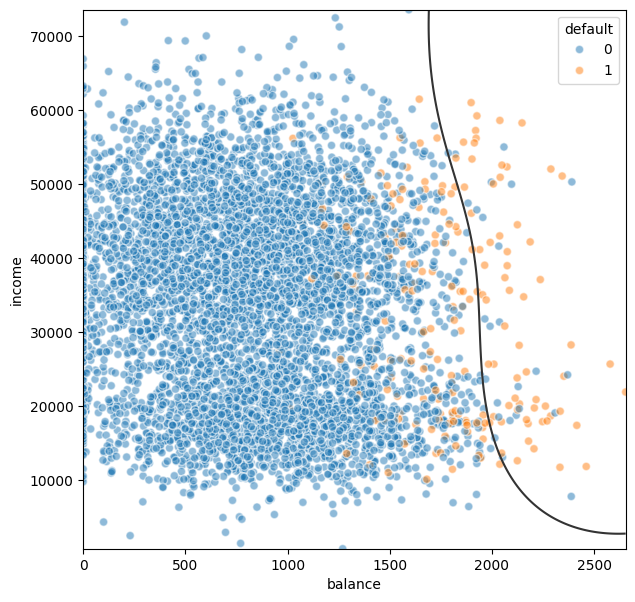

In [42]:
from sklearn.pipeline import Pipeline

model_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(penalty=None))
])

model_pipe.fit(X_bal_inc, y_train)

plot_decision_boundary(X_bal_inc["balance"], X_bal_inc["income"], y_train, model_pipe)


Adding polynomial transformations allows for non-linearities in the decision boundary.